# Random Forest Model for Prediciton of Sleep and Awake States

In [1]:
# Import needed libraries and packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

import random

import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")

RSEED=42


### Getting the Data into Dataframe

In [ ]:
# Define the directory containing the files
data_directory = 'data/file_per_night'

If you already run the following cells and have the files 'train_data.parquet' and 'test_data.parque' in the 'data/file_per_night' directory, you can skip the following cells and continue with importing those two files into new dataframes.

In [ ]:

# Get a list of all files in the directory
file_paths = [os.path.join(data_directory, file) for file in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, file))]

# Concatenate all dataframes into a single dataframe
dataframes = [pd.read_parquet(file) for file in file_paths]
full_dataframe = pd.concat(dataframes, ignore_index=True)

To have only two classes, we set the event 'onset' to 'awake' and 'wakeup' to 'sleep'

In [3]:
full_dataframe['event'].unique()

array(['awake', 'onset', 'sleep', 'wakeup'], dtype=object)

In [4]:
for i in full_dataframe.index:
    if full_dataframe['event'][i] == 'onset':
        full_dataframe['event'][i] = 'awake'
    elif full_dataframe['event'][i] == 'wakeup':
        full_dataframe['event'][i] = 'sleep'
    else:
        continue

full_dataframe['event'].unique()

array(['awake', 'sleep'], dtype=object)

### Remove Nas

In [ ]:
full_dataframe.isna().sum()

In [6]:
# remove Nas
full_dataframe.drop('night', axis = 1, inplace =True)
full_dataframe.dropna(inplace=True)

In [ ]:
full_dataframe.isna().sum()

### Train / Test Split

Next, we perform the regular train-test-split for training and evaluation of the model as usual:

In [8]:
# Split the data into train and test sets with stratification
train_data, test_data = train_test_split(full_dataframe, test_size=0.25, stratify=full_dataframe['event'], random_state=RSEED)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

Safe the train and test sets for later:

In [9]:
train_data.to_parquet(os.path.join(data_directory, "train_data.parquet"))
test_data.to_parquet(os.path.join(data_directory, "test_data.parquet"))

In [3]:
# use this to read the train and test set, if they were already created
train_data = pd.read_parquet(os.path.join(data_directory, "train_data.parquet"))
test_data = pd.read_parquet(os.path.join(data_directory, "test_data.parquet"))

In [4]:
train_data.head()

,anglez,enmo,step,anglez_std,enmo_std,series_id,slope_enmo,slope_anglez,anglez_outside_45_counter,enmo_over_008_counter,...,enmo_10min_std,enmo_10min_mean_shifted,enmo_10min_std_shifted,event,minutes_since_onset,year,month,day,hour,minute
0,-14.223984,0.003942,55889.5,17.420665,0.004248,db75092f0530,-0.001044,-2.988206,0,3,...,0.002640,0.008947,0.017574,awake,0.0,2018.0,6.0,10.0,18.0,22.0
1,-80.924500,0.000000,267617.5,0.000000,0.000000,8b159a98f485,0.000000,0.000000,12,0,...,0.000000,0.000000,0.000000,sleep,34.0,2019.0,6.0,12.0,21.0,56.0
2,28.887924,0.327517,350465.5,12.936250,0.190786,1716cd4163b2,-0.010472,0.678289,1,12,...,0.104317,0.372927,0.172498,awake,0.0,2019.0,5.0,23.0,19.0,15.0
3,12.347626,0.026342,62741.5,8.652647,0.016646,7504165f497d,-0.000198,0.904907,0,12,...,0.011654,0.021507,0.005416,awake,645.0,2017.0,9.0,25.0,7.0,38.0
4,-30.174082,0.024250,107537.5,1.352014,0.004262,8a22387617c3,-0.000633,0.212910,0,12,...,0.004228,0.027748,0.004891,awake,0.0,2018.0,8.0,19.0,21.0,36.0


### Preprocessing

For this model, we select all the newly engineered features that we created including several statistical values for the corresponding bins such as mean, standard deviation and maximum, but also so values associated with previous timepoints. For further information regarding feature engineering refer to [this file]().

In [12]:
# Extract features and target variable from the data
X_train = train_data.drop(['event', 'series_id', 'step'], axis=1).reset_index(drop=True)
y_train = train_data['event'].reset_index(drop=True)

X_test = test_data.drop(['event', "series_id", "step"], axis=1).reset_index(drop=True)
y_test = test_data['event'].reset_index(drop=True)

Oversamplig

In [ ]:
# For oversampling (because we have more sleep than awake states), we apply SMOTE
smote = SMOTE(random_state=RSEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train= X_train_smote
y_train = y_train_smote

If you want to reuse the 'smoted' data sets again (also for other models), you could now save it and afterwards only need to reload them.

In [ ]:
# Safe the oversampled train data into PARQUET and CSV files respectively
X_train.to_parquet(os.path.join(data_directory, "X_train_smote.parquet"))
y_train.to_csv(os.path.join(data_directory, "y_train_smote.csv"))

In [29]:
# Use this to reload the oversampled train data
X_train = pd.read_parquet(os.path.join(data_directory, "X_train_smote.parquet"))
y_train = pd.read_csv(os.path.join(data_directory, "y_train_smote.csv"))['event']

X_test = test_data.drop(['event', "series_id", "step"], axis=1).reset_index(drop=True)
y_test = test_data['event'].reset_index(drop=True)

Scaling

In [20]:
# Preprossessing of features
scaler = MinMaxScaler()

# Scaling of features
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[5.01291104e-01, 3.10054302e-02, 1.17703925e-01, ...,
        5.00000000e-01, 3.91304348e-01, 2.20338983e-01],
       [3.09890226e-01, 7.49325600e-04, 4.59269376e-02, ...,
        9.66666667e-01, 2.17391304e-01, 7.79661017e-01],
       [3.82330718e-01, 9.59850402e-03, 4.65260328e-01, ...,
        4.66666667e-01, 9.13043478e-01, 6.94915254e-01],
       ...,
       [6.98523919e-01, 0.00000000e+00, 0.00000000e+00, ...,
        7.00000000e-01, 2.17391304e-01, 9.66101695e-01],
       [6.28358761e-02, 7.85007778e-04, 1.14381941e-01, ...,
        5.66666667e-01, 4.34782609e-02, 3.22033898e-01],
       [4.20580900e-01, 1.10269806e-02, 1.53085439e-01, ...,
        7.33333333e-01, 3.47826087e-01, 5.59322034e-01]])

## Setting up and training of the model

Model type: Random Forest

In [21]:
# Initialize the Classifier
model = RandomForestClassifier(n_estimators= 10, random_state=RSEED, max_depth=10)

In [39]:
# Train the model on the training data
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=10, random_state=42)

In [40]:
# Make predictions on the test data
y_pred = model.predict(X_test)

Evaluation of the model performance:

In [41]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy on test data: {accuracy:.2%}")
print(f"Precision on test data: {precision:.2%}")
print(f"Recall on test data: {recall:.2%}")
print(f"F1 Score on test data: {f1:.2%}")

Accuracy on test data: 97.05%
Precision on test data: 97.06%
Recall on test data: 97.05%
F1 Score on test data: 97.06%


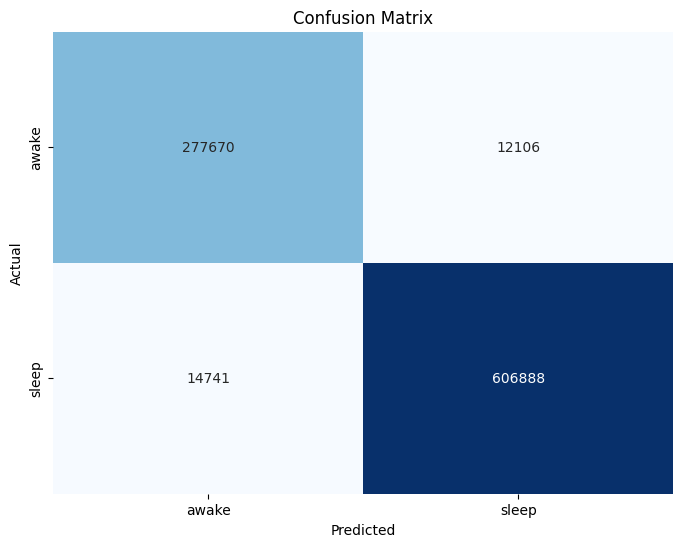

In [42]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.xticks(ticks = [0.5,1.5], labels= ['awake', 'sleep'])
plt.ylabel('Actual')
plt.yticks(ticks = [0.5,1.5], labels= ['awake', 'sleep'])
plt.title('Confusion Matrix')
plt.show()

## Grid Search

To find a better performing model, we perform a grid search testing different parameters:

In [20]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [5, 100, 250],
    'max_depth': [5, 10, 20],
}

# Initialize the Decision Tree Classifier
modelCV = RandomForestClassifier(random_state = RSEED)

In [21]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(modelCV, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'n_estimators': [5, 100, 250]},
             scoring='accuracy')

In [22]:
# Print the best parameters and corresponding accuracy
best_params = grid_search.best_params_
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'n_estimators': 250}
Best Accuracy: 0.8941993242657306


### Validation of best model

In [24]:
best_model = RandomForestClassifier(max_depth = 20, n_estimators=250)

In [25]:
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=250)

In [26]:
y_pred_best = best_model.predict(X_test)

In [27]:
accuracy = accuracy_score(list(y_test), list(y_pred_best))
precision = precision_score(list(y_test), list(y_pred_best), average='weighted')
recall = recall_score(list(y_test), list(y_pred_best), average='weighted')
f1 = f1_score(list(y_test), list(y_pred_best), average='weighted')

print(f"Accuracy on test data: {accuracy:.2%}")
print(f"Precision on test data: {precision:.2%}")
print(f"Recall on test data: {recall:.2%}")
print(f"F1 Score on test data: {f1:.2%}")

Accuracy on test data: 88.81%
Precision on test data: 89.20%
Recall on test data: 88.81%
F1 Score on test data: 88.93%


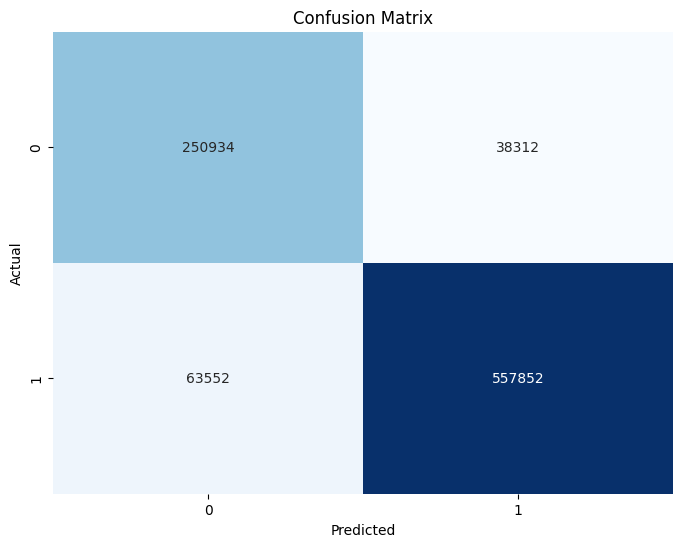

In [28]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.xticks(ticks = [0.5,1.5], labels= ['awake', 'sleep'])
plt.ylabel('Actual')
plt.yticks(ticks = [0.5,1.5], labels= ['awake', 'sleep'])
plt.title('Confusion Matrix')
plt.show()